<a href="https://colab.research.google.com/github/ssabrut/traffic-sign-classification/blob/main/Traffic_Signs_Classification_using_Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import files

# uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle
# !chmod 600 ~/.kaggle/kaggle.json

In [3]:
# !kaggle datasets download -d valentynsichkar/traffic-signs-preprocessed

Dataset URL: https://www.kaggle.com/datasets/valentynsichkar/traffic-signs-preprocessed
License(s): other
100% 4.16G/4.16G [03:43<00:00, 20.9MB/s]
100% 4.16G/4.16G [03:43<00:00, 20.0MB/s]


In [4]:
# !unzip traffic-signs-preprocessed.zip

Archive:  traffic-signs-preprocessed.zip
  inflating: data0.pickle            
  inflating: data1.pickle            
  inflating: data2.pickle            
  inflating: data3.pickle            
  inflating: data4.pickle            
  inflating: data5.pickle            
  inflating: data6.pickle            
  inflating: data7.pickle            
  inflating: data8.pickle            
  inflating: datasets_preparing.py   
  inflating: label_names.csv         
  inflating: labels.pickle           
  inflating: mean_image_gray.pickle  
  inflating: mean_image_rgb.pickle   
  inflating: std_gray.pickle         
  inflating: std_rgb.pickle          
  inflating: test.pickle             
  inflating: train.pickle            
  inflating: valid.pickle            


In [54]:
# from IPython.display import clear_output

# !pip install -qq -U tensorflow-addons
# clear_output()

In [5]:
import os

os.environ["KERAS_BACKEND"] = "jax"

### Data loading

In [6]:
import pandas as pd
import numpy as np

data = pd.read_pickle('data8.pickle')
data.keys()

dict_keys(['y_validation', 'x_train', 'y_train', 'x_validation', 'labels', 'x_test', 'y_test'])

In [37]:
label_mapping = pd.read_csv('label_names.csv')
label_mapping.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [22]:
X_train = data['x_train']
X_valid = data['x_validation']
X_test = data['x_test']
print('X_train shape:', X_train.shape)
print('X_valid shape:', X_valid.shape)
print('X_test shape:', X_test.shape)

X_train shape: (86989, 1, 32, 32)
X_valid shape: (4410, 1, 32, 32)
X_test shape: (12630, 1, 32, 32)


In [23]:
y_train = data['y_train']
y_valid = data['y_validation']
y_test = data['y_test']
print('y_train shape:', y_train.shape)
print('y_valid shape:', y_valid.shape)
print('y_test shape:', y_test.shape)

y_train shape: (86989,)
y_valid shape: (4410,)
y_test shape: (12630,)


In [24]:
def swap_axes(dataset):
  dataset = dataset.swapaxes(1,2)
  dataset = dataset.swapaxes(2,3)
  return dataset

In [25]:
X_train = swap_axes(X_train)
X_valid = swap_axes(X_valid)
X_test = swap_axes(X_test)
print('X_train shape:', X_train.shape)
print('X_valid shape:', X_valid.shape)
print('X_test shape:', X_test.shape)

X_train shape: (86989, 32, 32, 1)
X_valid shape: (4410, 32, 32, 1)
X_test shape: (12630, 32, 32, 1)


### Data visualization

In [50]:
from matplotlib import pyplot as plt

def plot_image(dataset, label):
  plt.figure(figsize=(10,10))
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(dataset[i], cmap = "gray")
    plt.title(label_mapping.loc[label_mapping['ClassId'] == label[i], 'SignName'].values[0], fontsize=6)
    plt.axis("off")
  plt.tight_layout()
  plt.show()

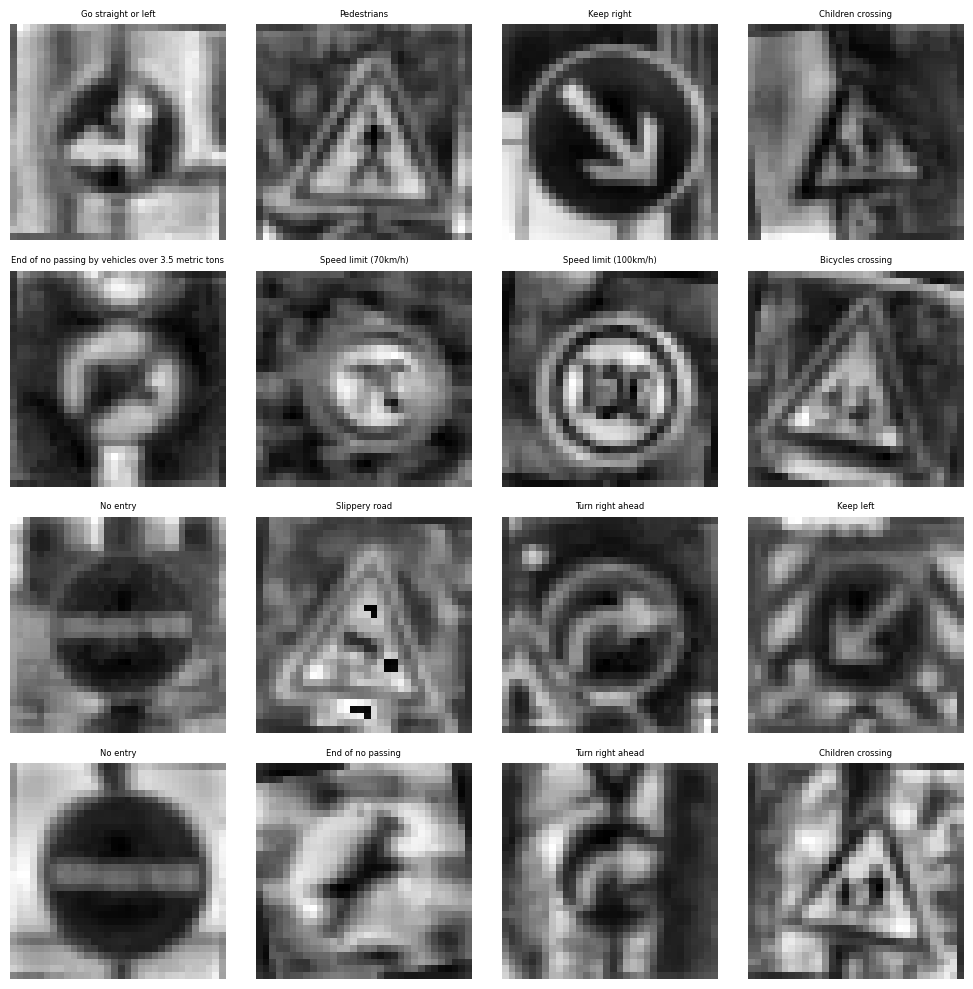

In [51]:
plot_image(X_train, y_train)

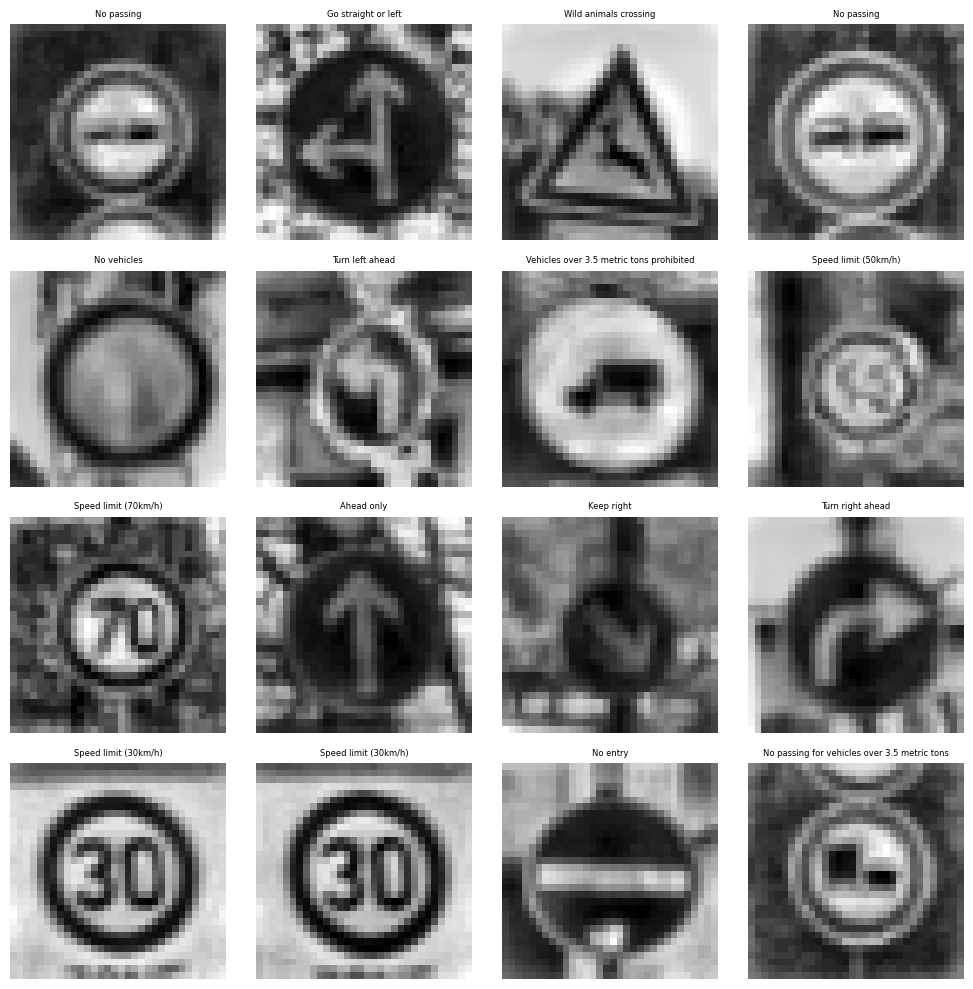

In [52]:
plot_image(X_valid, y_valid)

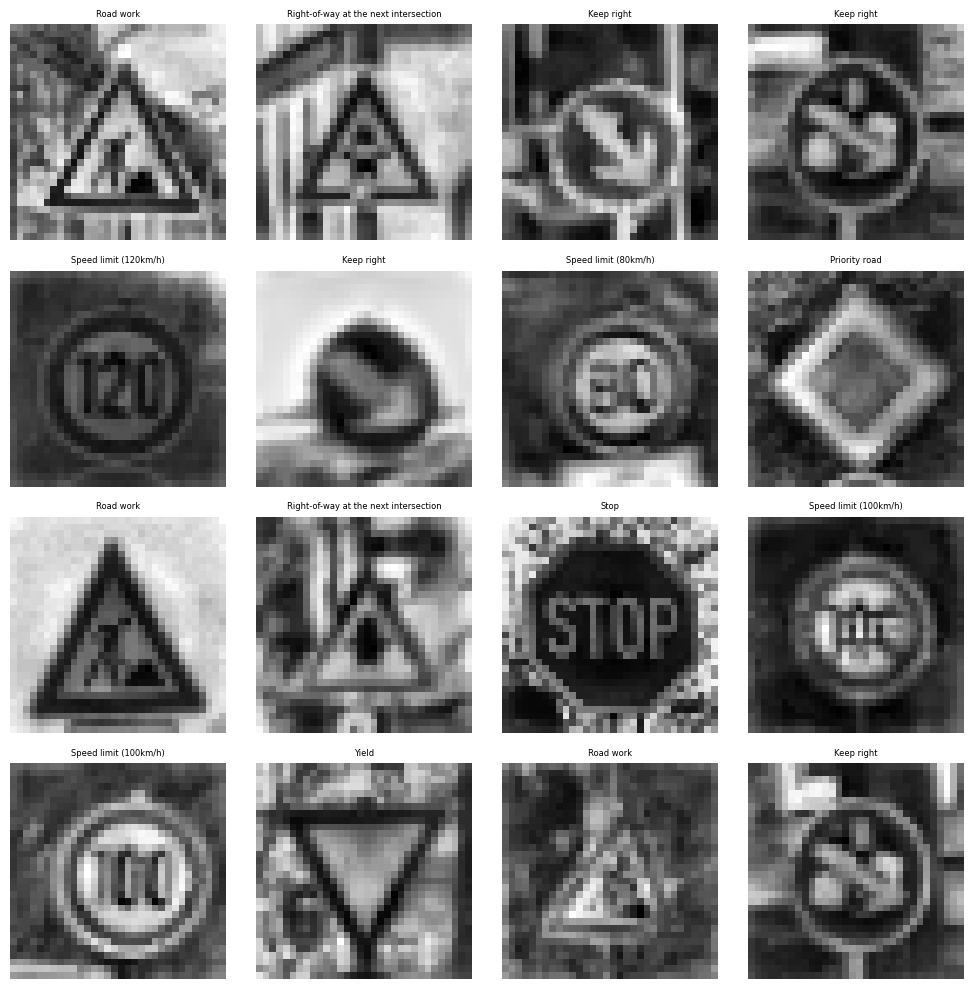

In [53]:
plot_image(X_test, y_test)

# Configure hyperparameters

In [56]:
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 256

# AUGMENTATION
IMAGE_SIZE = 72
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

# TRAINING
EPOCHS = 50

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [PROJECTION_DIM * 2, PROJECTION_DIM]
MLP_HEAD_UNITS = [2048, 1024]

### Implement shifted patch token layer

In a ViT pipeline, the input images are divided into patches that are then linearly projected into tokens. Shifted patch tokenization (STP) is introduced to combat the low receptive field of ViTs. The steps for Shifted Patch Tokenization are as follows:


* Start with an image.
* Shift the image in diagonal directions.
* Concat the diagonally shifted images with the original image.
* Extract patches of the concatenated images.
* Flatten the spatial dimension of all patches.
* Layer normalize the flattened patches and then project it.

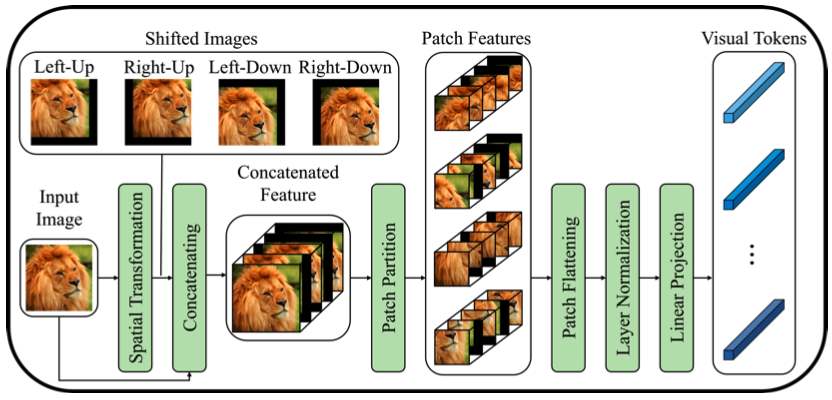

In [67]:
from tensorflow import keras
from keras import layers
import tensorflow as tf

class ShiftedPatchTokenization(layers.Layer):
  def __init__(
      self,
      image_size=IMAGE_SIZE,
      patch_size=PATCH_SIZE,
      num_patches=NUM_PATCHES,
      projection_dim=PROJECTION_DIM,
      vanilla=False,
      **kwargs
  ):
    super().__init__(**kwargs)
    self.vanilla = vanilla
    self.image_size = image_size,
    self.patch_size = patch_size
    self.half_patch = patch_size // 2
    self.flatten_patches = layers.Reshape((num_patches, -1))
    self.projection = layers.Dense(units=projection_dim)
    self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

  def crop_shift_pad(self, images, mode):
    # Build the diagonally shifted images
    if mode == "left-up":
        crop_height = self.half_patch
        crop_width = self.half_patch
        shift_height = 0
        shift_width = 0
    elif mode == "left-down":
        crop_height = 0
        crop_width = self.half_patch
        shift_height = self.half_patch
        shift_width = 0
    elif mode == "right-up":
        crop_height = self.half_patch
        crop_width = 0
        shift_height = 0
        shift_width = self.half_patch
    else:
        crop_height = 0
        crop_width = 0
        shift_height = self.half_patch
        shift_width = self.half_patch

    # Crop the shifted images and pad them
    crop = tf.image.crop_to_bounding_box(
        images,
        offset_height=crop_height,
        offset_width=crop_width,
        target_height=self.image_size - self.half_patch,
        target_width=self.image_size - self.half_patch,
    )
    shift_pad = tf.image.pad_to_bounding_box(
        crop,
        offset_height=shift_height,
        offset_width=shift_width,
        target_height=self.image_size,
        target_width=self.image_size,
    )
    return shift_pad

  def call(self, images):
    if not self.vanilla:
        # Concat the shifted images with the original image
        images = tf.concat(
            [
                images,
                self.crop_shift_pad(images, mode="left-up"),
                self.crop_shift_pad(images, mode="left-down"),
                self.crop_shift_pad(images, mode="right-up"),
                self.crop_shift_pad(images, mode="right-down"),
            ],
            axis=-1,
        )
    # Patchify the images and flatten it
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, self.patch_size, self.patch_size, 1],
        strides=[1, self.patch_size, self.patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    flat_patches = self.flatten_patches(patches)
    if not self.vanilla:
        # Layer normalize the flat patches and linearly project it
        tokens = self.layer_norm(flat_patches)
        tokens = self.projection(tokens)
    else:
        # Linearly project the flat patches
        tokens = self.projection(flat_patches)
    return (tokens, patches)